<a href="https://colab.research.google.com/github/ValentinKraravchenko/System-Analysis/blob/main/%D0%9B%D0%B0%D0%B11%D0%A1%D0%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная работа №1. 
Модели анализа и прогнозирования нестационарных стохастических временных рядов, порождаемых сложными динамическими объектами. Метод модовой декомпозиции.

 

Кравченко Валентин 4232м

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
import scipy as sp
from scipy import signal

Шаг 1. Загрузка данных. Данные взяты за период от 04.02.2015 по 04.02.2016 https://investfunds.ru/indexes/224/

In [ ]:
uploaded = files.upload()
data = pd.read_excel("gold.xlsx")
data.head()

Saving gold.xlsx to gold.xlsx


,Дата,Значение
0,2016-02-04,2879.52
1,2016-02-03,2815.09
2,2016-02-02,2753.33
3,2016-02-01,2689.71
4,2016-01-30,2689.71


Шаг 2. Визуализация Временного ряда.

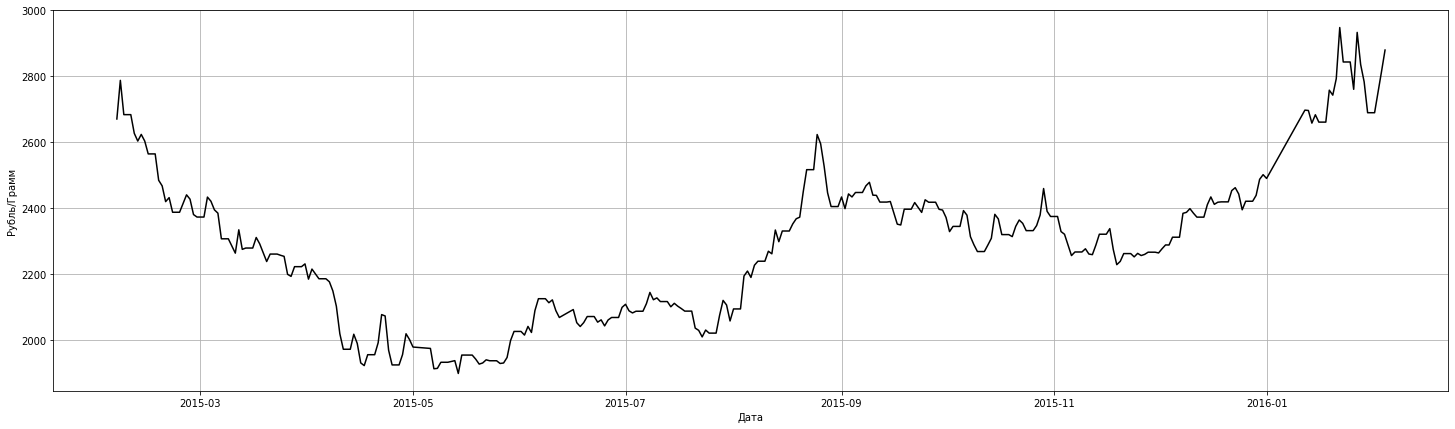

In [ ]:

x = data.values[:, 0]
y = data.values[:, 1]
last_y=y[-1]
x=x[:-1]
y=y[:-1]
plt.figure(figsize=(25,7))
plt.xlabel('Дата')
plt.ylabel('Рубль/Грамм')
plt.grid()
plt.plot(x, y,'k')
plt.show()

Шаг 3. Начало реализации алгоритма EMD. Определяются все локальные экстремумы ВР

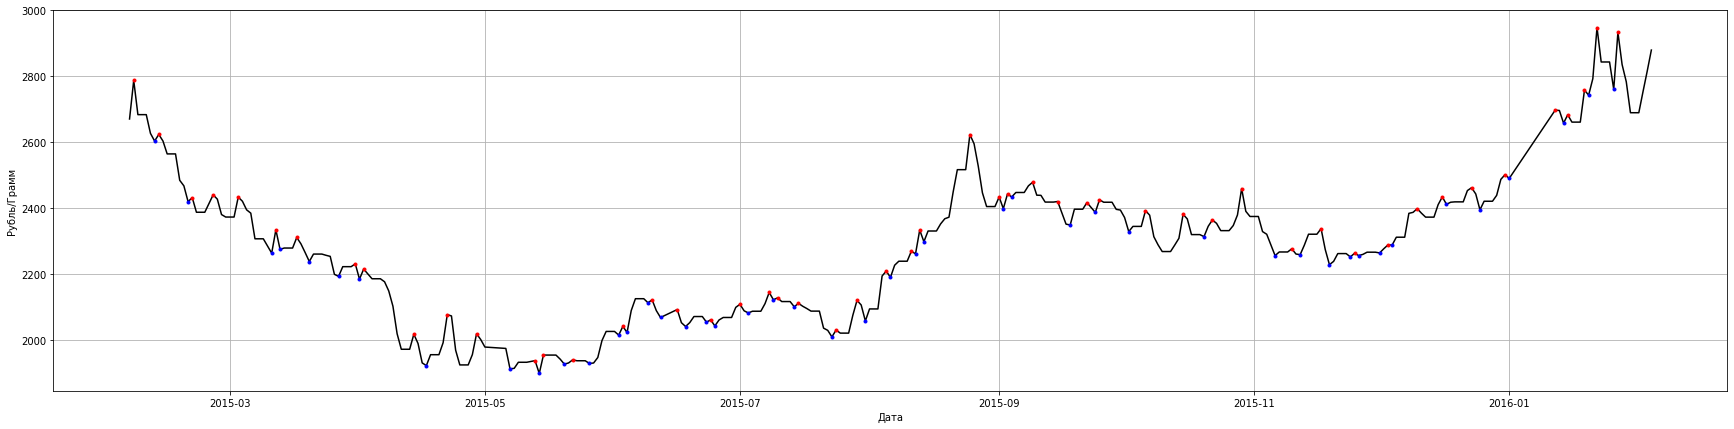

In [ ]:
pks = signal.argrelmax(y)[0]
trs = signal.argrelmin(y)[0]
plt.figure(figsize=(30,7))
plt.plot(x, y,'k')
plt.plot(x[pks],y[pks],'r.')
plt.plot(x[trs],y[trs],'b.')
plt.xlabel('Дата')
plt.ylabel('Рубль/Грамм')
plt.grid()
plt.show()


Шаг 4. Кубическим сплайном вычисляются верхняя (красный цвет) и
нижняя (синий цвет) огибающие ВР.

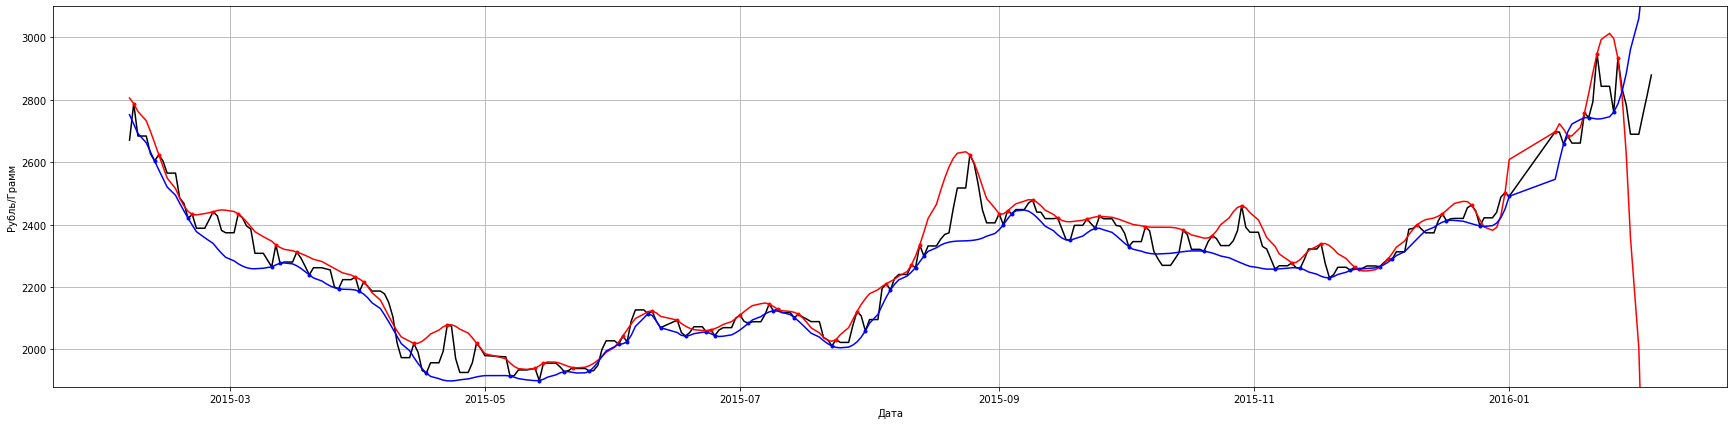

In [ ]:
y_pks = y[pks]
fip = sp.interpolate.InterpolatedUnivariateSpline(pks,y_pks,k=3)
pks_x = fip(range(len(y)))
y_trs = y[trs]
fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,y_trs,k=3)
trs_x = fitr(range(len(y)))
plt.figure(figsize=(30,7))
plt.plot(x,y,'k')
plt.plot(x[pks],y[pks],'r.')
plt.plot(x[trs],y[trs],'b.')
plt.plot(x,pks_x,'r')
plt.plot(x,trs_x,'b')
plt.xlabel('Дата')
plt.ylabel('Рубль/Грамм')
plt.ylim([1880,3100])
plt.grid()
plt.show()

Шаг 5. Определяется функция средних
значений.

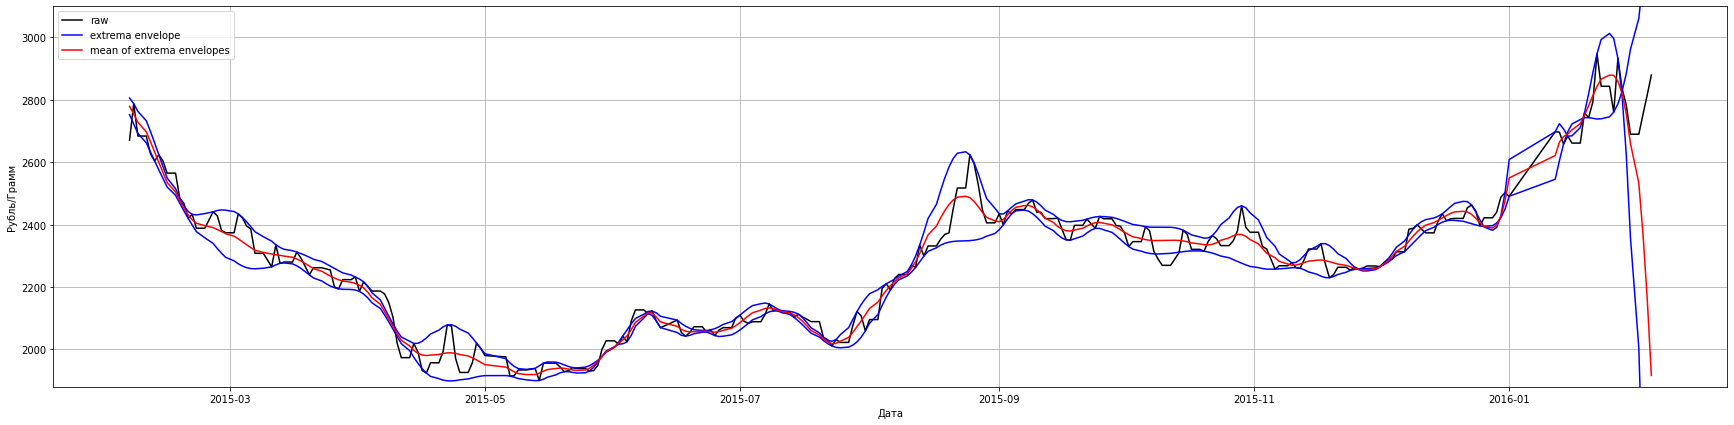

In [ ]:
medium = (pks_x + trs_x) / 2
plt.figure(figsize=(30,7))
plt.plot(x,y,'k',label='raw')
plt.plot(x,pks_x,'b',label='extrema envelope')
plt.plot(x,trs_x,'b')
plt.plot(x,medium,'r',label='mean of extrema envelopes')
plt.xlabel('Дата')
plt.ylabel('Рубль/Грамм')
plt.ylim([1880,3100])
plt.legend(loc='best')
plt.grid()
plt.show()

Шаг 6.Критерий останова внутренних итераций.

In [ ]:
def _emd_comperror(h, mean, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))

Шаг 7. Функция расчета медианы.


In [ ]:
def _emd_complim(medium, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    medium[:samp_start] = medium[samp_start]
    medium[samp_end:] = medium[samp_end]
    return medium

Шаг 8. Написание функции расчета EMD.

In [ ]:
def emd(x, nIMF , stoplim = .001):  
    r = y
    x=list(range(1,297))
    t = x
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            medium = (pks_t + trs_t) / 2
            medium = _emd_complim(medium, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, medium, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - medium
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs,r
imfs,r = emd(x, nIMF = 4)

Шаг 8. Визуализация полученных результатов.

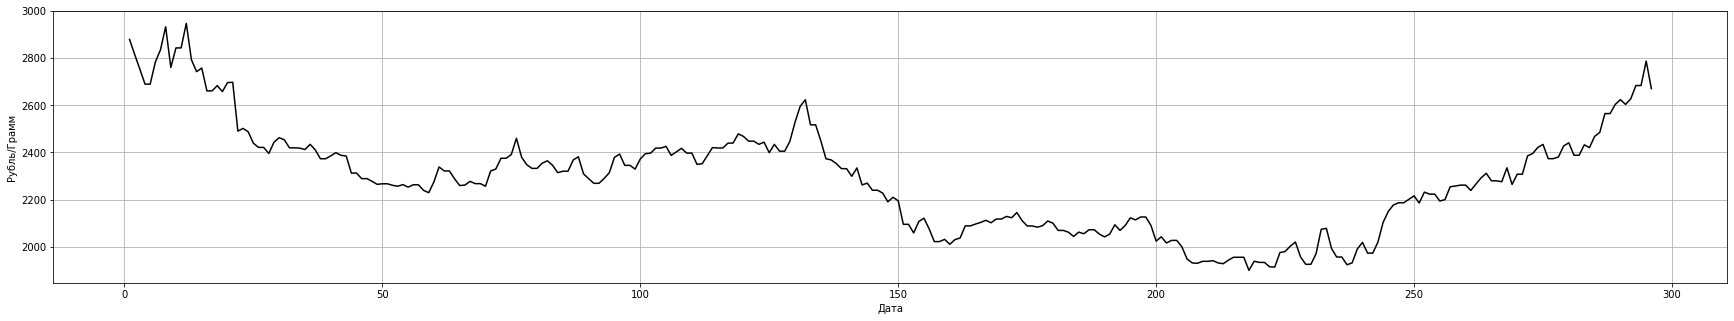

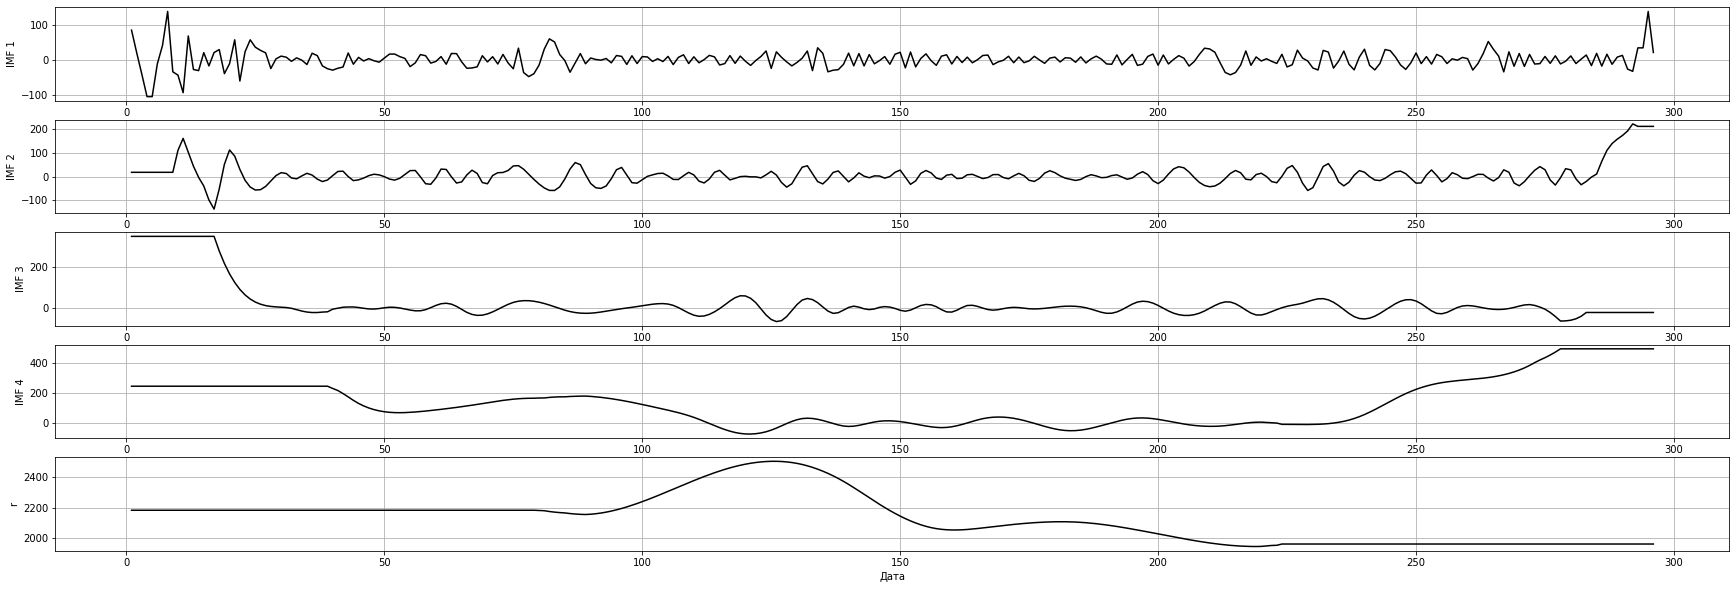

In [ ]:
plt.figure(figsize=(30,5))
x=list(range(1,297))
plt.plot(x,y,'k')
plt.xlabel('Дата')
plt.ylabel('Рубль/Грамм')
plt.grid()


plt.figure(figsize=(30,10))
for i in range(len(imfs)):
    plt.subplot(len(imfs)+1,1,i+1)
    plt.plot(x,imfs[i],'k')
    plt.ylabel('IMF '+str(i+1))
    plt.grid()
    if i == len(imfs)-1:
        plt.xlabel('Дата')
plt.subplot(len(imfs)+1,1,len(imfs)+1)
plt.plot(x,r,'k')
plt.xlabel('Дата')
plt.ylabel('r')
plt.grid()


Шаг 9. Восстановление ВР.


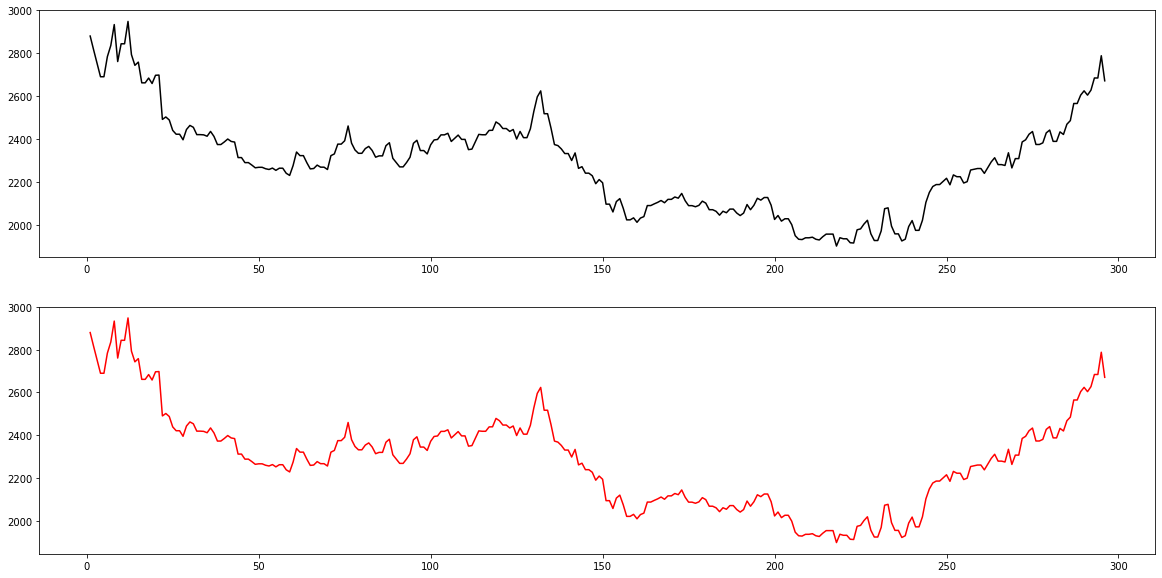

In [ ]:

plt.figure(figsize=(20,10))
plt.xlabel('Дата')
plt.ylabel('Рубль/Грамм')
plt.grid()

plt.subplot(2,1,1)

plt.plot(x,y,'k')
result=imfs[0]+imfs[1]+imfs[2]+imfs[3]+r
plt.subplot(2,1,2)
plt.plot(x,result,'r')
plt.show()

Шаг 10. Прогноз динамики.


In [ ]:
from scipy.interpolate import splev, splrep
last_point= []
result = []
for i in imfs:
  y_pks = i+r
  spl = splrep(x, y_pks)
  x2 = np.linspace(0, len(i)+1, (len(i)+1)*10)
  y2 = splev(x2, spl)
  last_point.append(y2[-1])
for i in range(0,len(imfs)-1):
  for j in range(i+1,len(imfs)):
    y_pks = imfs[i]+imfs[j]+r
    spl = splrep(x, y_pks)
    x2 = np.linspace(0, len(imfs[i])+1, (len(imfs[i])+1)*10)
    y2 = splev(x2, spl)
    last_point.append(y2[-1])
for i in last_point:
  result.append(abs(i-last_y))
print(f"{min(result)} {result.index(min(result))} " )


111.71788696194517 8 
